In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
%matplotlib inline

from IPython.display import HTML

In [16]:
imageDir = '/home/user1/Desktop/sdc_project/LaneDetection/Curved-Lane-Lines/test_images/image.png'
#imageFiles = os.listdir(imageDir)
imageList = []

#for i in range(0, len(imageDir)):
imageList = mpimg.imread('/home/user1/Desktop/sdc_project/LaneDetection/Curved-Lane-Lines/test_images/image.png')

print(imageList)









[[[0.34509805 0.44313726 0.65882355]
  [0.34509805 0.44313726 0.65882355]
  [0.34509805 0.44313726 0.65882355]
  ...
  [0.3529412  0.34509805 0.38431373]
  [0.30980393 0.30588236 0.34117648]
  [0.27450982 0.26666668 0.30588236]]

 [[0.34509805 0.44313726 0.65882355]
  [0.34509805 0.44313726 0.65882355]
  [0.34509805 0.44313726 0.65882355]
  ...
  [0.30588236 0.29803923 0.3372549 ]
  [0.28627452 0.28235295 0.31764707]
  [0.27058825 0.2627451  0.3019608 ]]

 [[0.34509805 0.44313726 0.65882355]
  [0.34509805 0.44313726 0.65882355]
  [0.34509805 0.44313726 0.65882355]
  ...
  [0.29411766 0.29803923 0.33333334]
  [0.29803923 0.3019608  0.3372549 ]
  [0.29803923 0.3019608  0.3372549 ]]

 ...

 [[0.36862746 0.36862746 0.38431373]
  [0.36862746 0.36862746 0.38431373]
  [0.36862746 0.36862746 0.38431373]
  ...
  [0.4392157  0.43529412 0.45490196]
  [0.4392157  0.43529412 0.45490196]
  [0.4392157  0.43529412 0.45490196]]

 [[0.36862746 0.36862746 0.38431373]
  [0.36862746 0.36862746 0.38431373]


/home/user1/.virtualenvs/sdc_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


ValueError: num must be 1 <= num <= 6, not 7

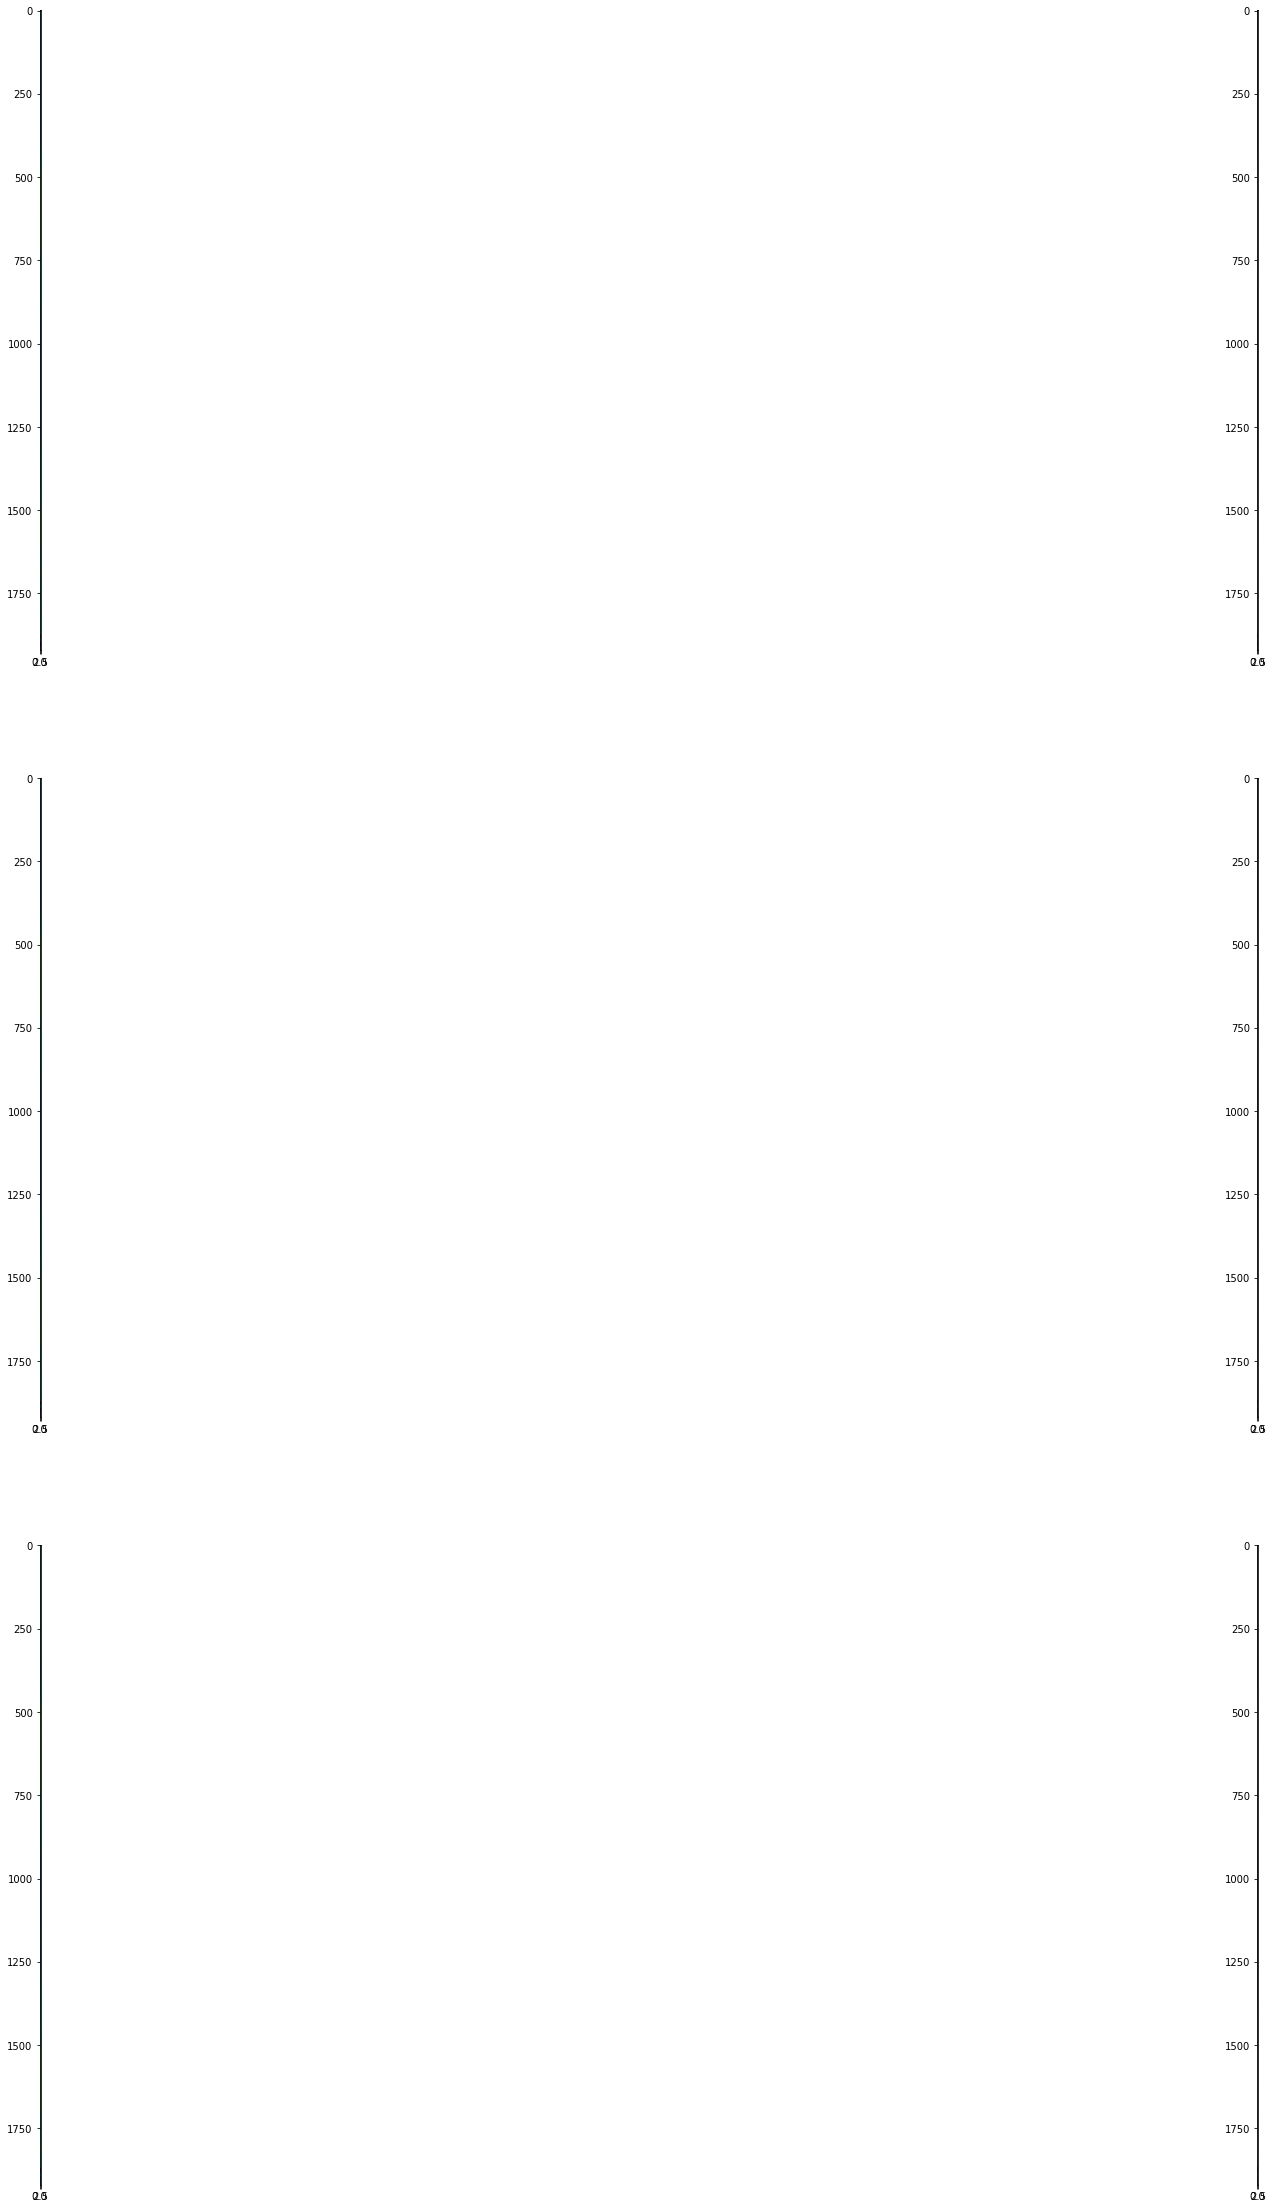

In [21]:
def display_images(images, cmap=None):
    plt.figure(figsize=(40,40))    
    for i, image in enumerate(images):
        if i==0:
            plt.subplot(3,2,i+1)
            plt.imshow(image, cmap)
            plt.autoscale(tight=True)
        plt.show()
    
display_images(imageList)


0
1
2
3
4
5
6


ValueError: num must be 1 <= num <= 6, not 7

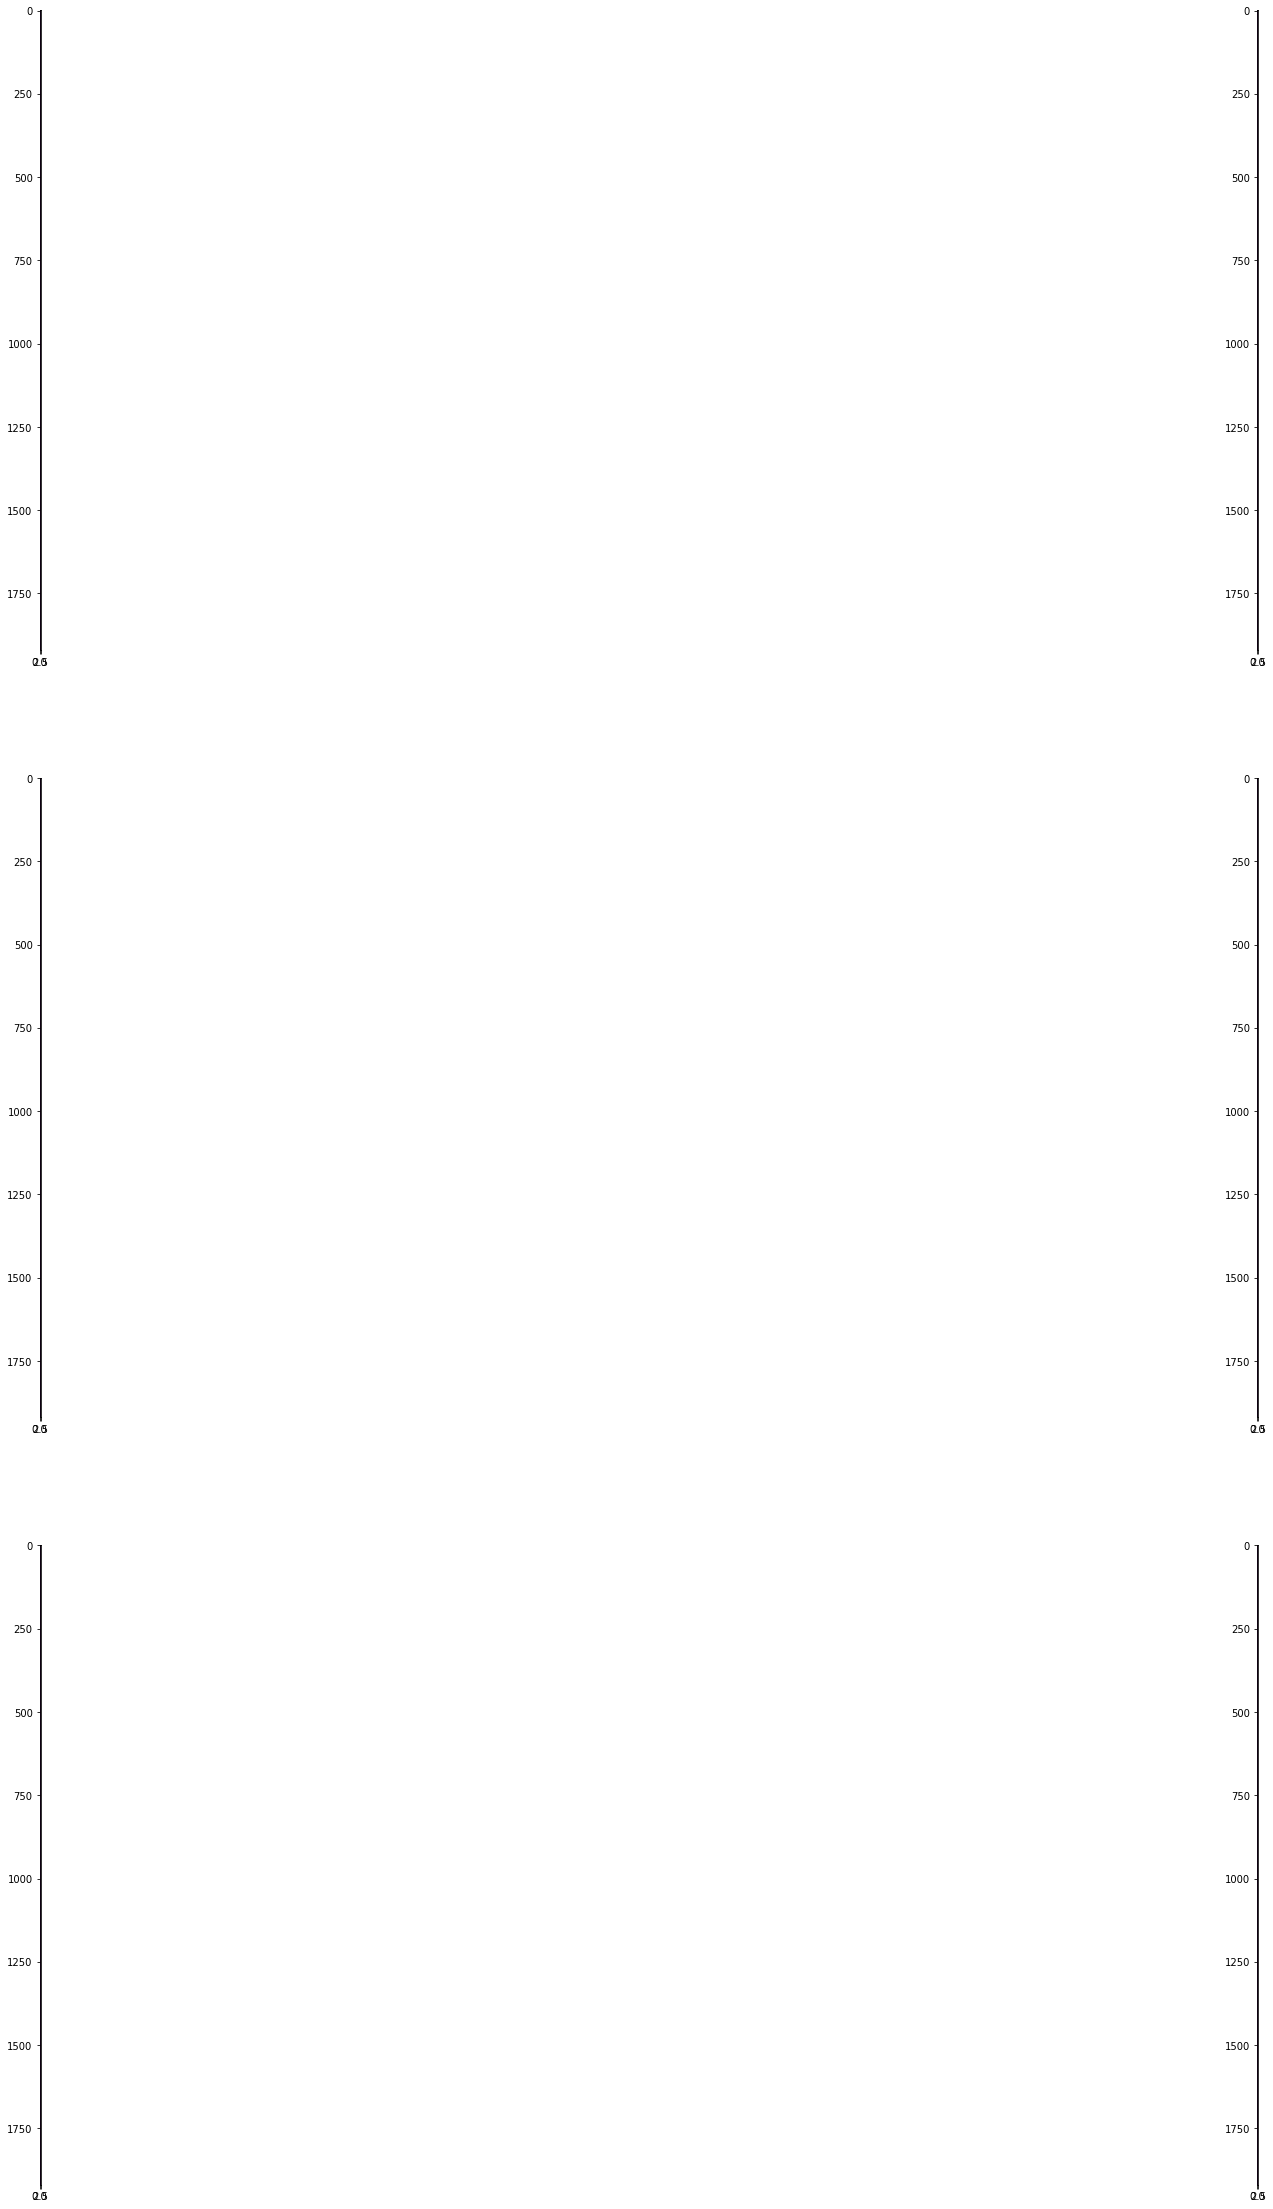

In [7]:
def color_filter(image):
    #convert to HLS to mask based on HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    display_images(hls)
    lower = np.array([0,98,0])
    upper = np.array([255,255,255])
    
    yellower = np.array([10,0,90])
    yelupper = np.array([50,255,255])
    
    yellowmask = cv2.inRange(hls, yellower, yelupper)    
    whitemask = cv2.inRange(hls, lower, upper)
    
    mask = cv2.bitwise_or(yellowmask, whitemask)  
    masked = cv2.bitwise_and(image, image, mask = mask)    
    


    return masked

filtered_img = list(map(color_filter, imageList))

display_images(filtered_img)

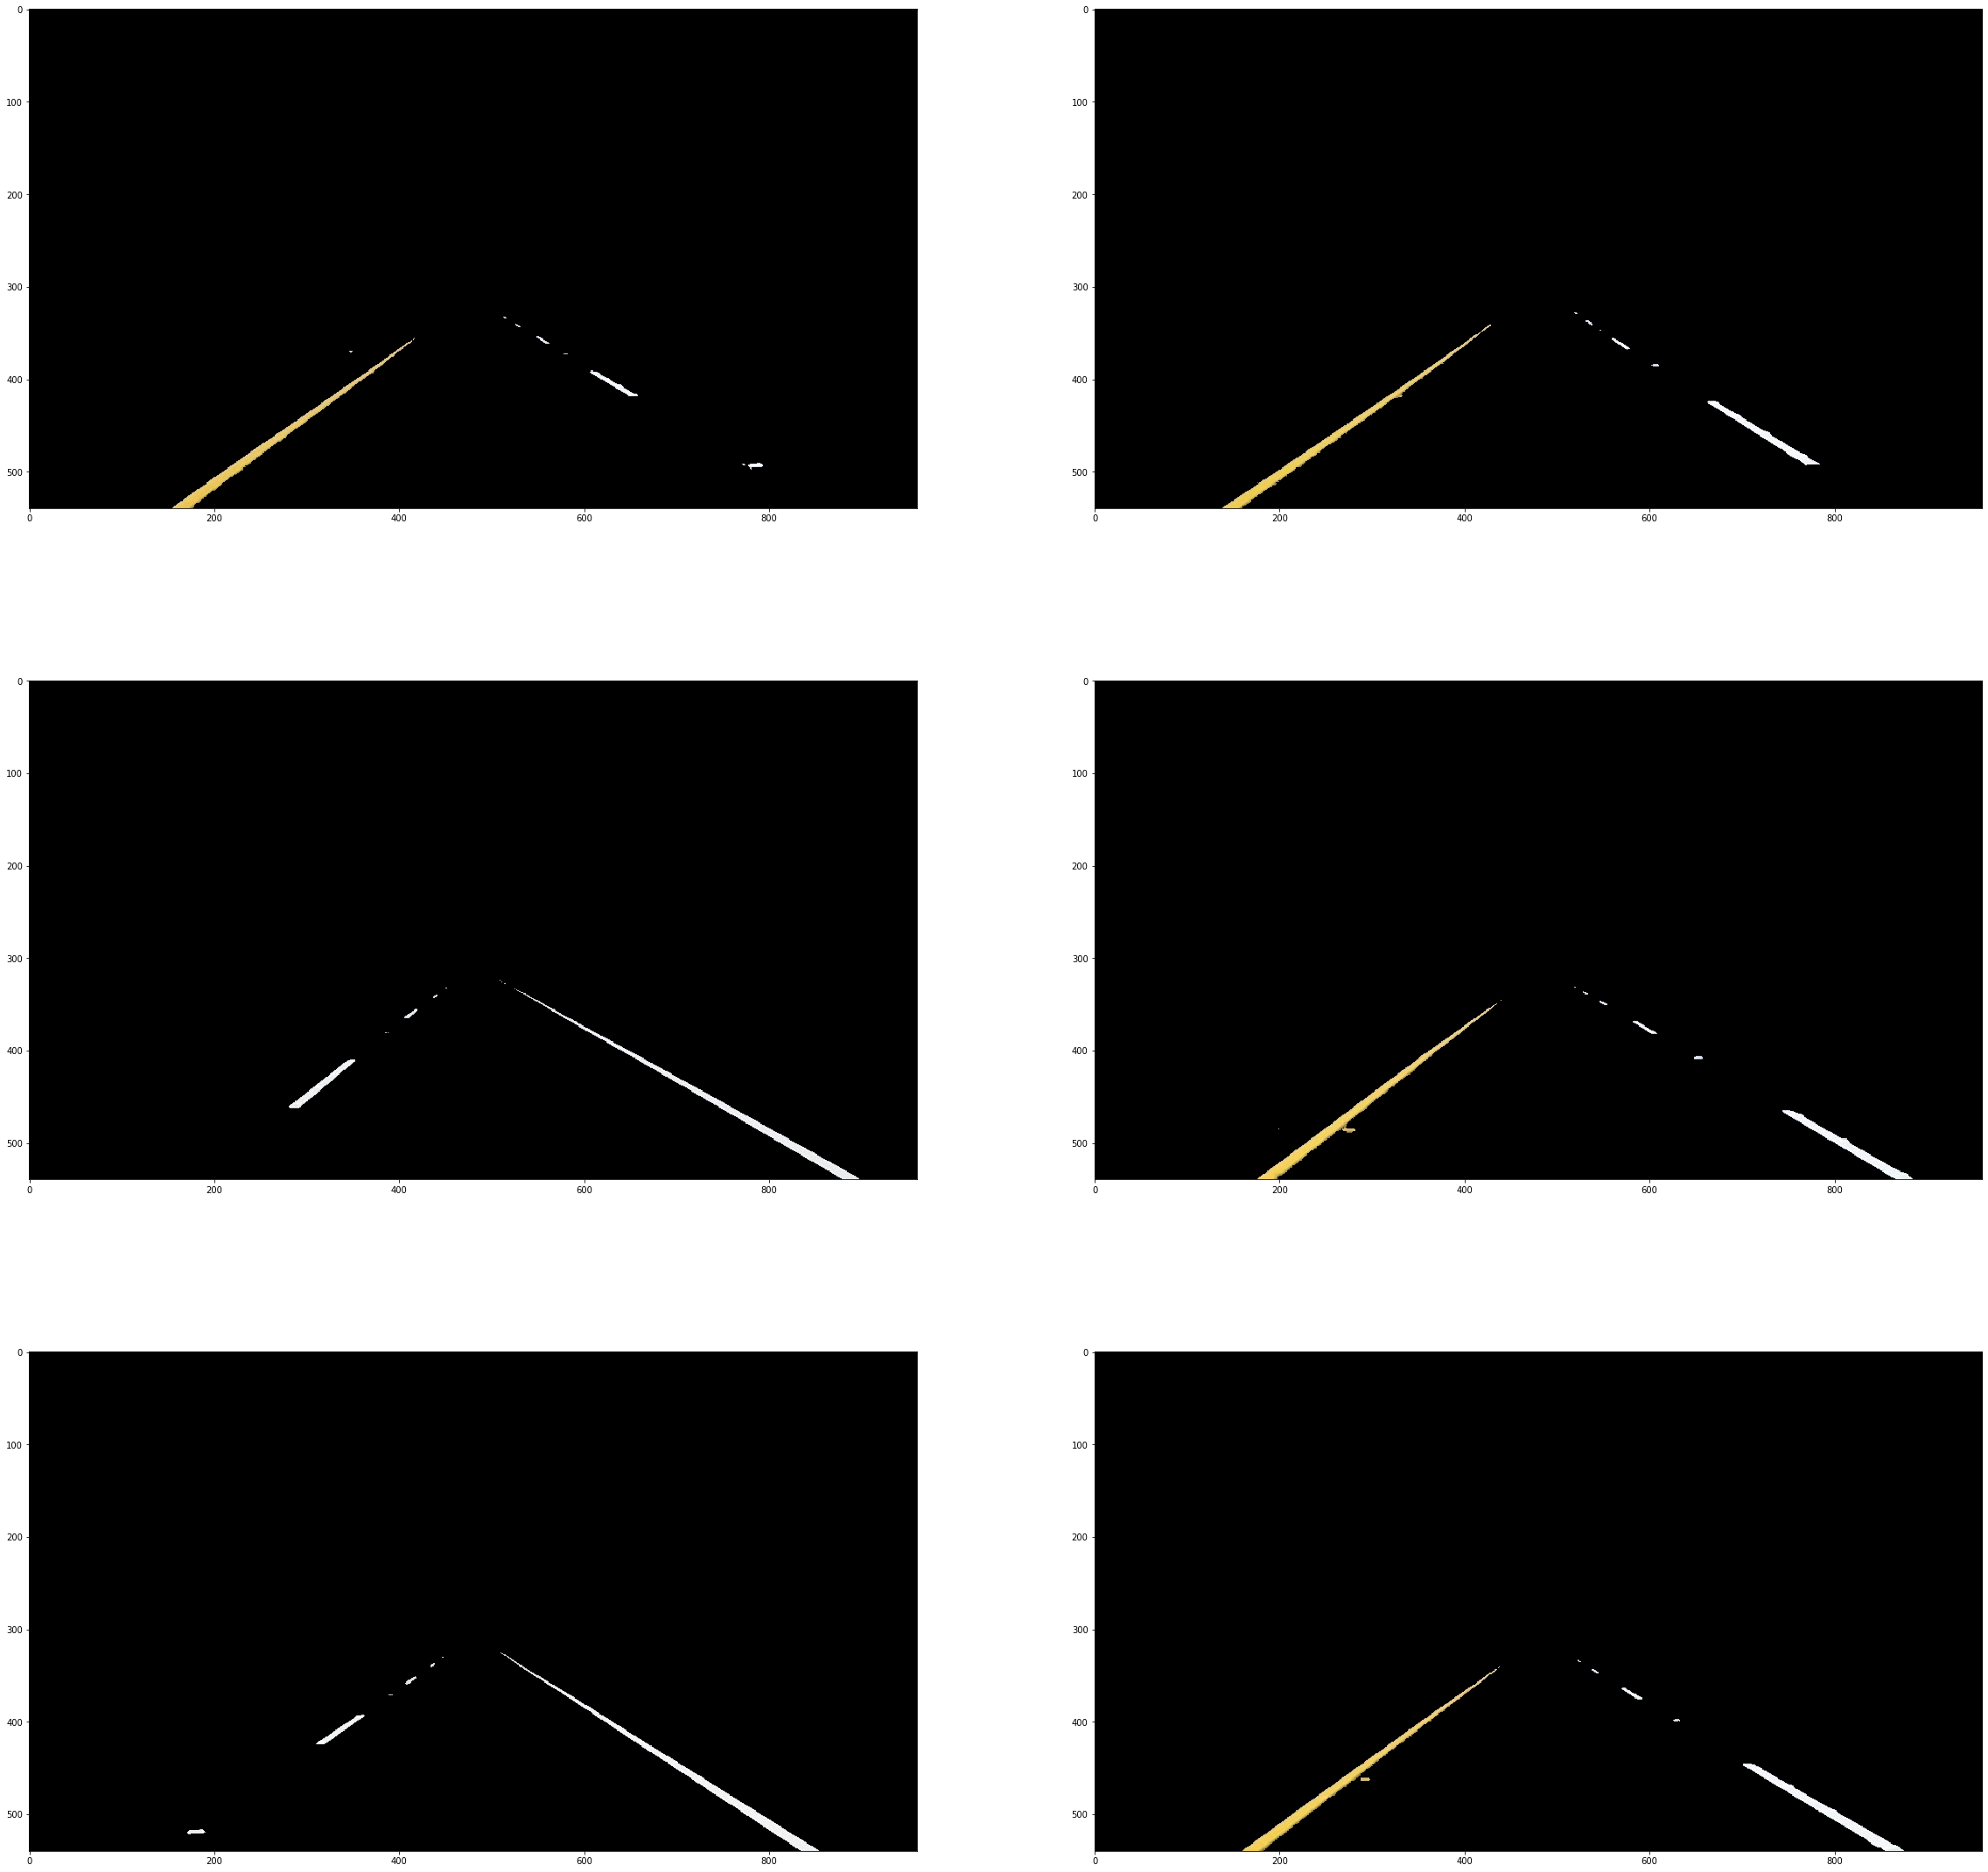

In [6]:
def roi(img):
    x = int(img.shape[1])
    y = int(img.shape[0])
    shape = np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]])

    #define a numpy array with the dimensions of img, but comprised of zeros
    mask = np.zeros_like(img)

    #Uses 3 channels or 1 channel for color depending on input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #creates a polygon with the mask color
    cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)

    #returns the image only where the mask pixels are not zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

roi_img = list(map(roi, filtered_img))

display_images(roi_img)



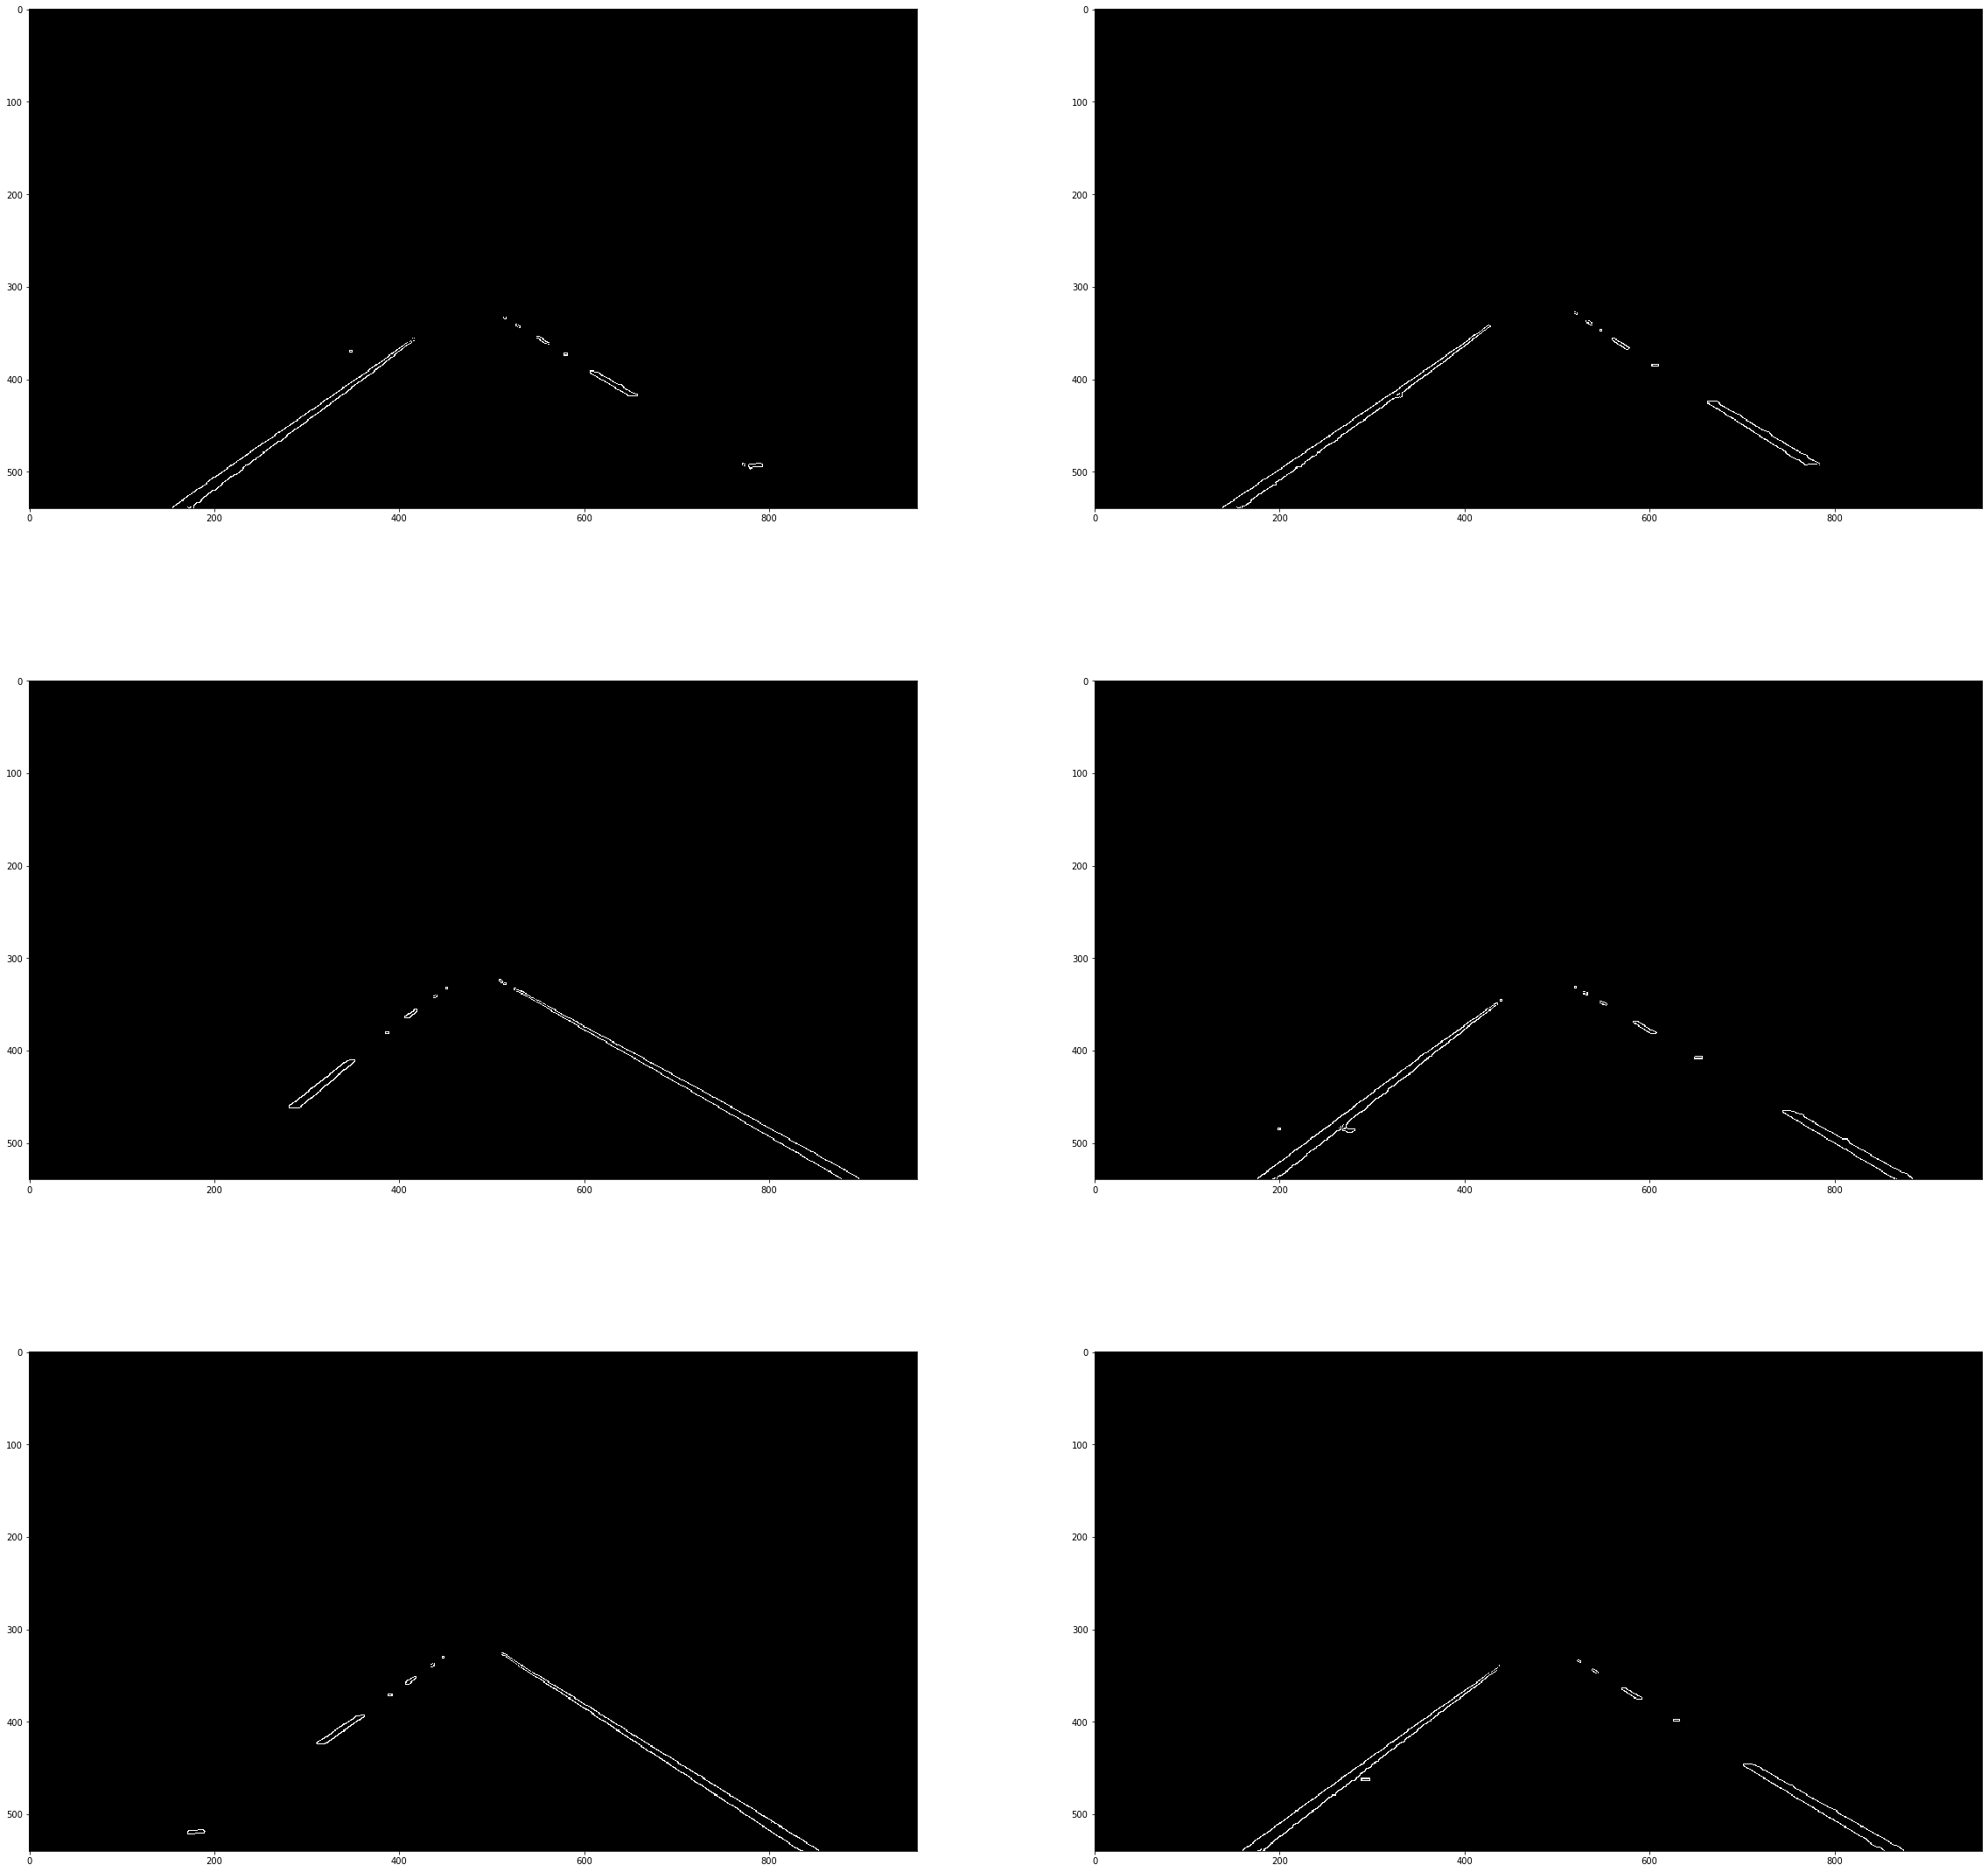

In [7]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img):
    return cv2.Canny(grayscale(img), 50, 120)

canny_img = list(map(canny, roi_img))
display_images(canny_img,cmap='gray')

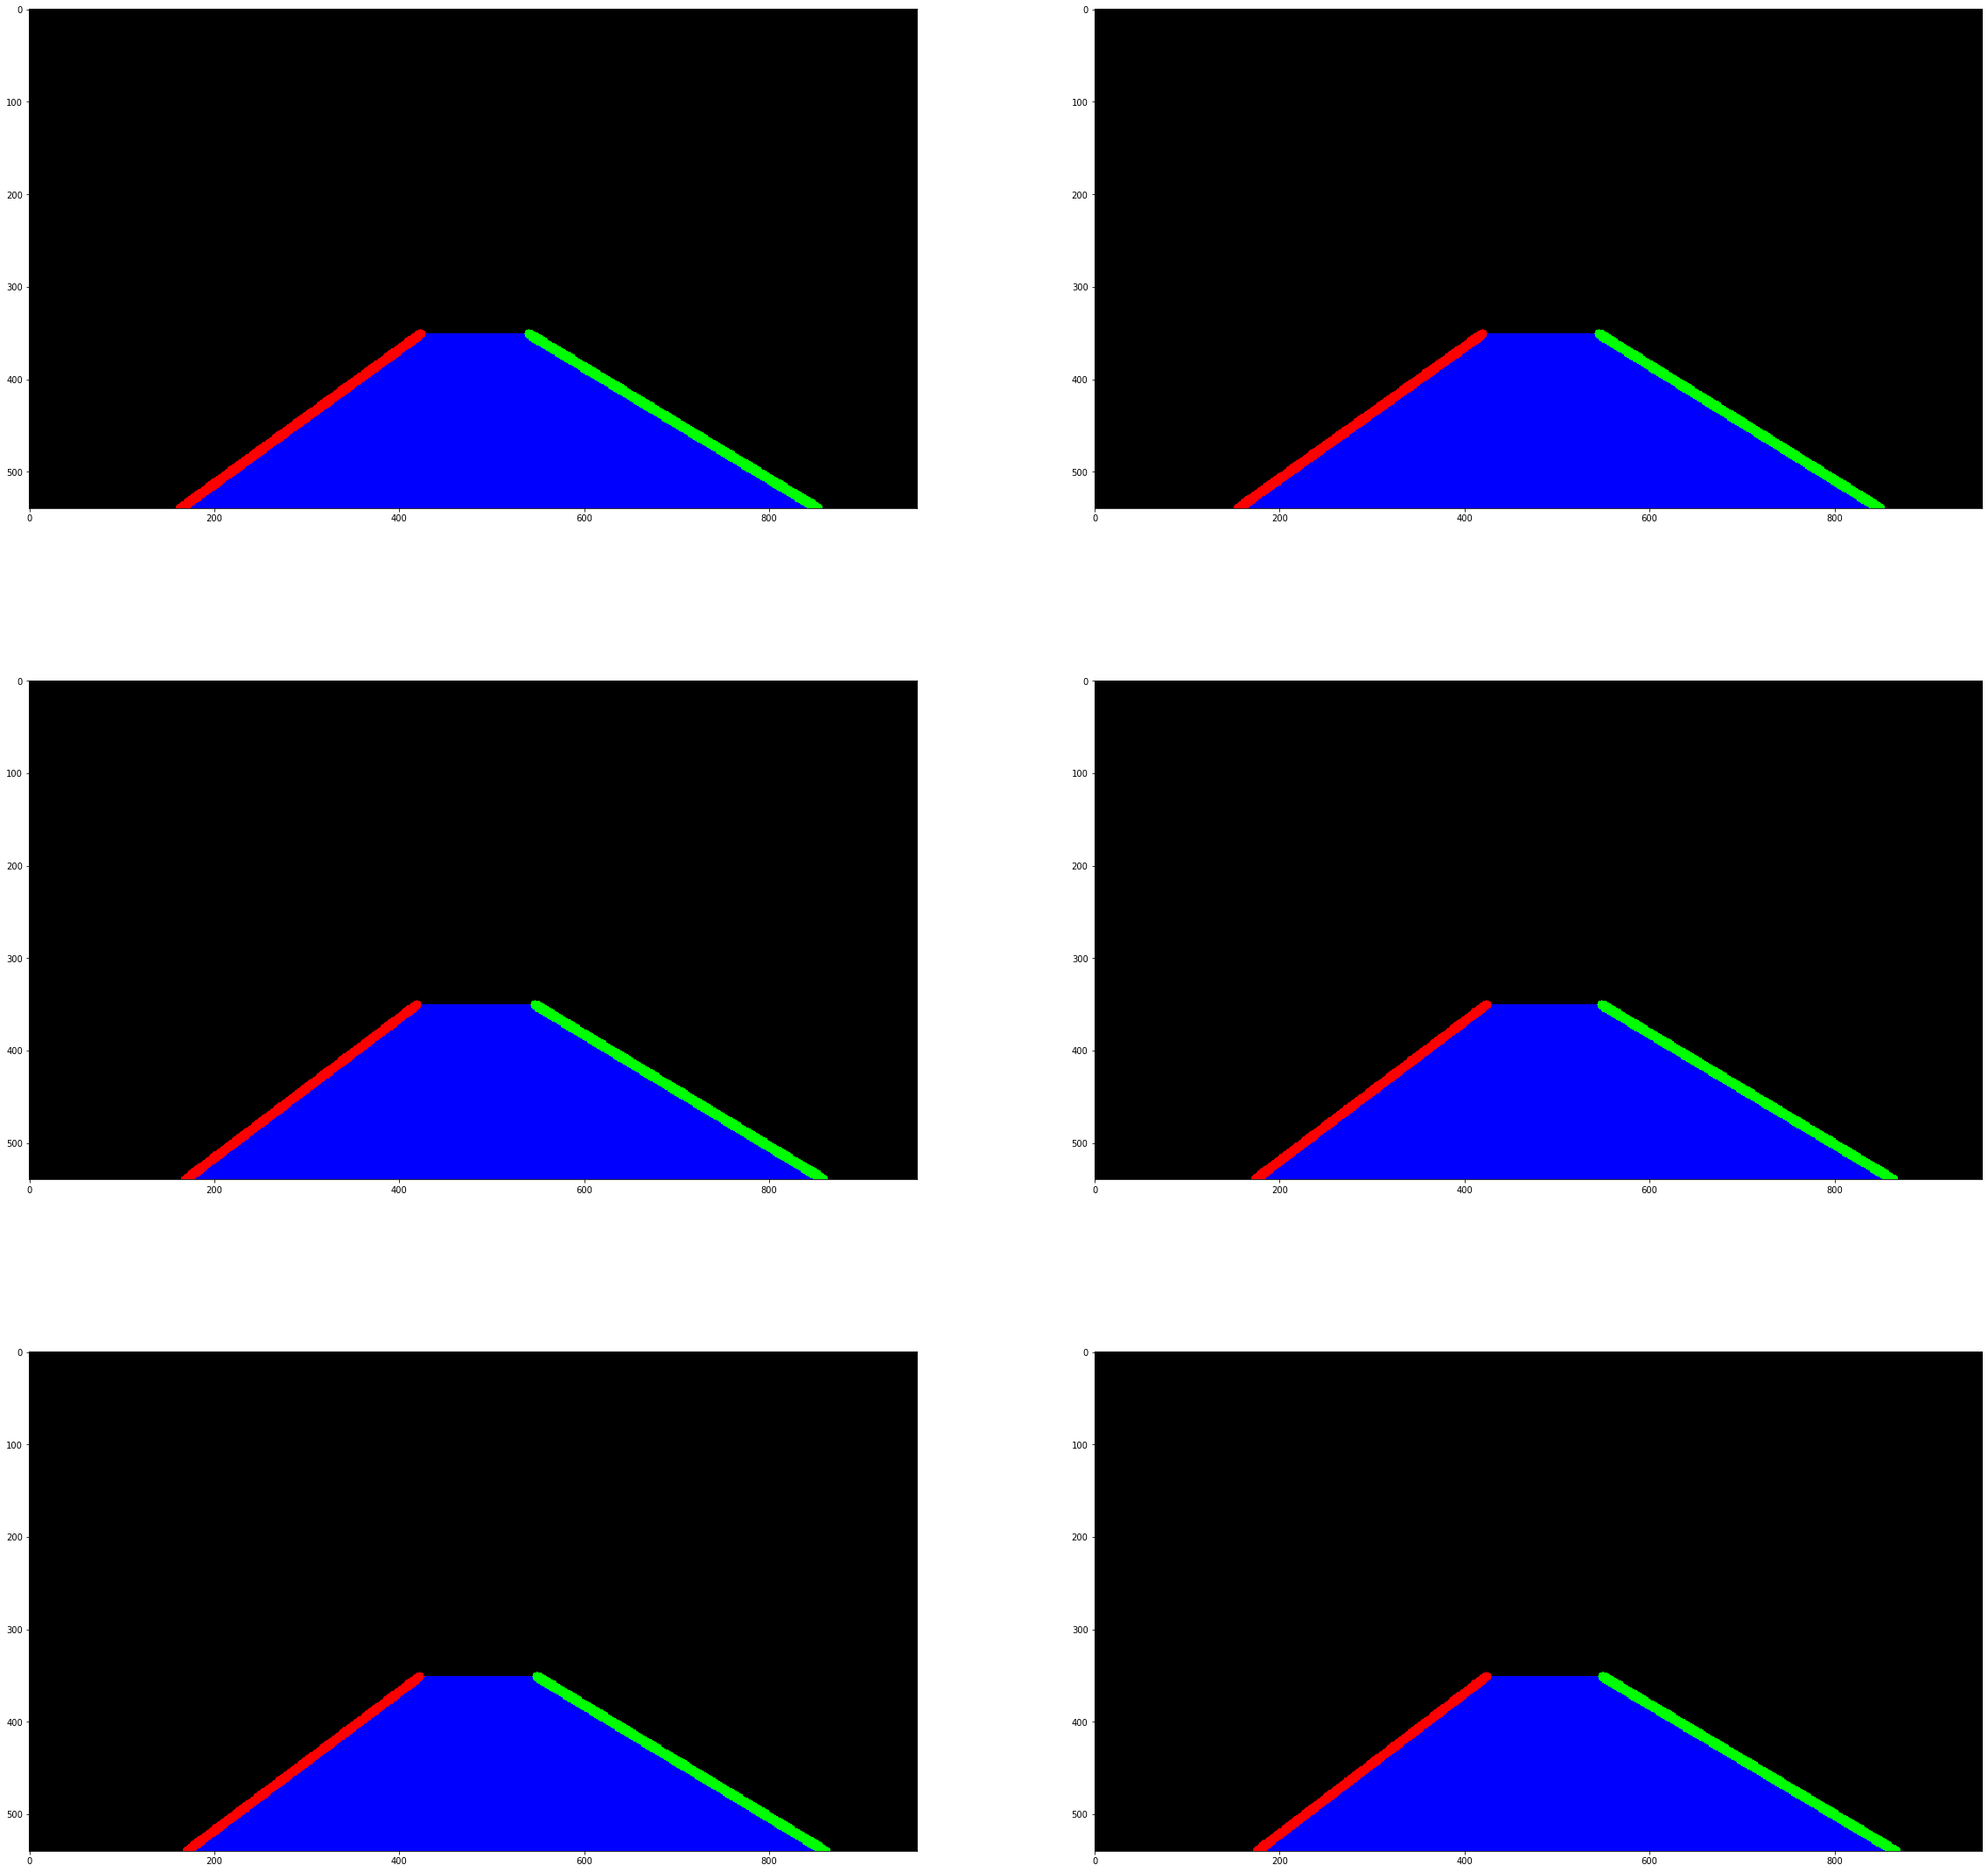

In [8]:
rightSlope, leftSlope, rightIntercept, leftIntercept = [],[],[],[]
def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept
    rightColor=[0,255,0]
    leftColor=[255,0,0]
    
    #this is used to filter out the outlying lines that can affect the average
    #We then use the slope we determined to find the y-intercept of the filtered lines by solving for b in y=mx+b
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if slope > 0.3:
                if x1 > 500 :
                    yintercept = y2 - (slope*x2)                    
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
                else: None                
            elif slope < -0.3:
                if x1 < 600:
                    yintercept = y2 - (slope*x2)                    
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)    
                    
                    
    #We use slicing operators and np.mean() to find the averages of the 30 previous frames
    #This makes the lines more stable, and less likely to shift rapidly
    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])
    
    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])
    
    
    #Here we plot the lines and the shape of the lane using the average slope and intercepts
    try:
        left_line_x1 = int((0.65*img.shape[0] - leftavgIntercept)/leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept)/leftavgSlope)
    
        right_line_x1 = int((0.65*img.shape[0] - rightavgIntercept)/rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept)/rightavgSlope)

        pts = np.array([[left_line_x1, int(0.65*img.shape[0])],[left_line_x2, int(img.shape[0])],[right_line_x2, int(img.shape[0])],[right_line_x1, int(0.65*img.shape[0])]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(img,[pts],(0,0,255))      
        
        
        cv2.line(img, (left_line_x1, int(0.65*img.shape[0])), (left_line_x2, int(img.shape[0])), leftColor, 10)
        cv2.line(img, (right_line_x1, int(0.65*img.shape[0])), (right_line_x2, int(img.shape[0])), rightColor, 10)
    except ValueError:
            #I keep getting errors for some reason, so I put this here. Idk if the error still persists.
        pass
    
    
    
                
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def linedetect(img):
    return hough_lines(img, 1, np.pi/180, 10, 20, 100)

hough_img = list(map(linedetect, canny_img))
display_images(hough_img)



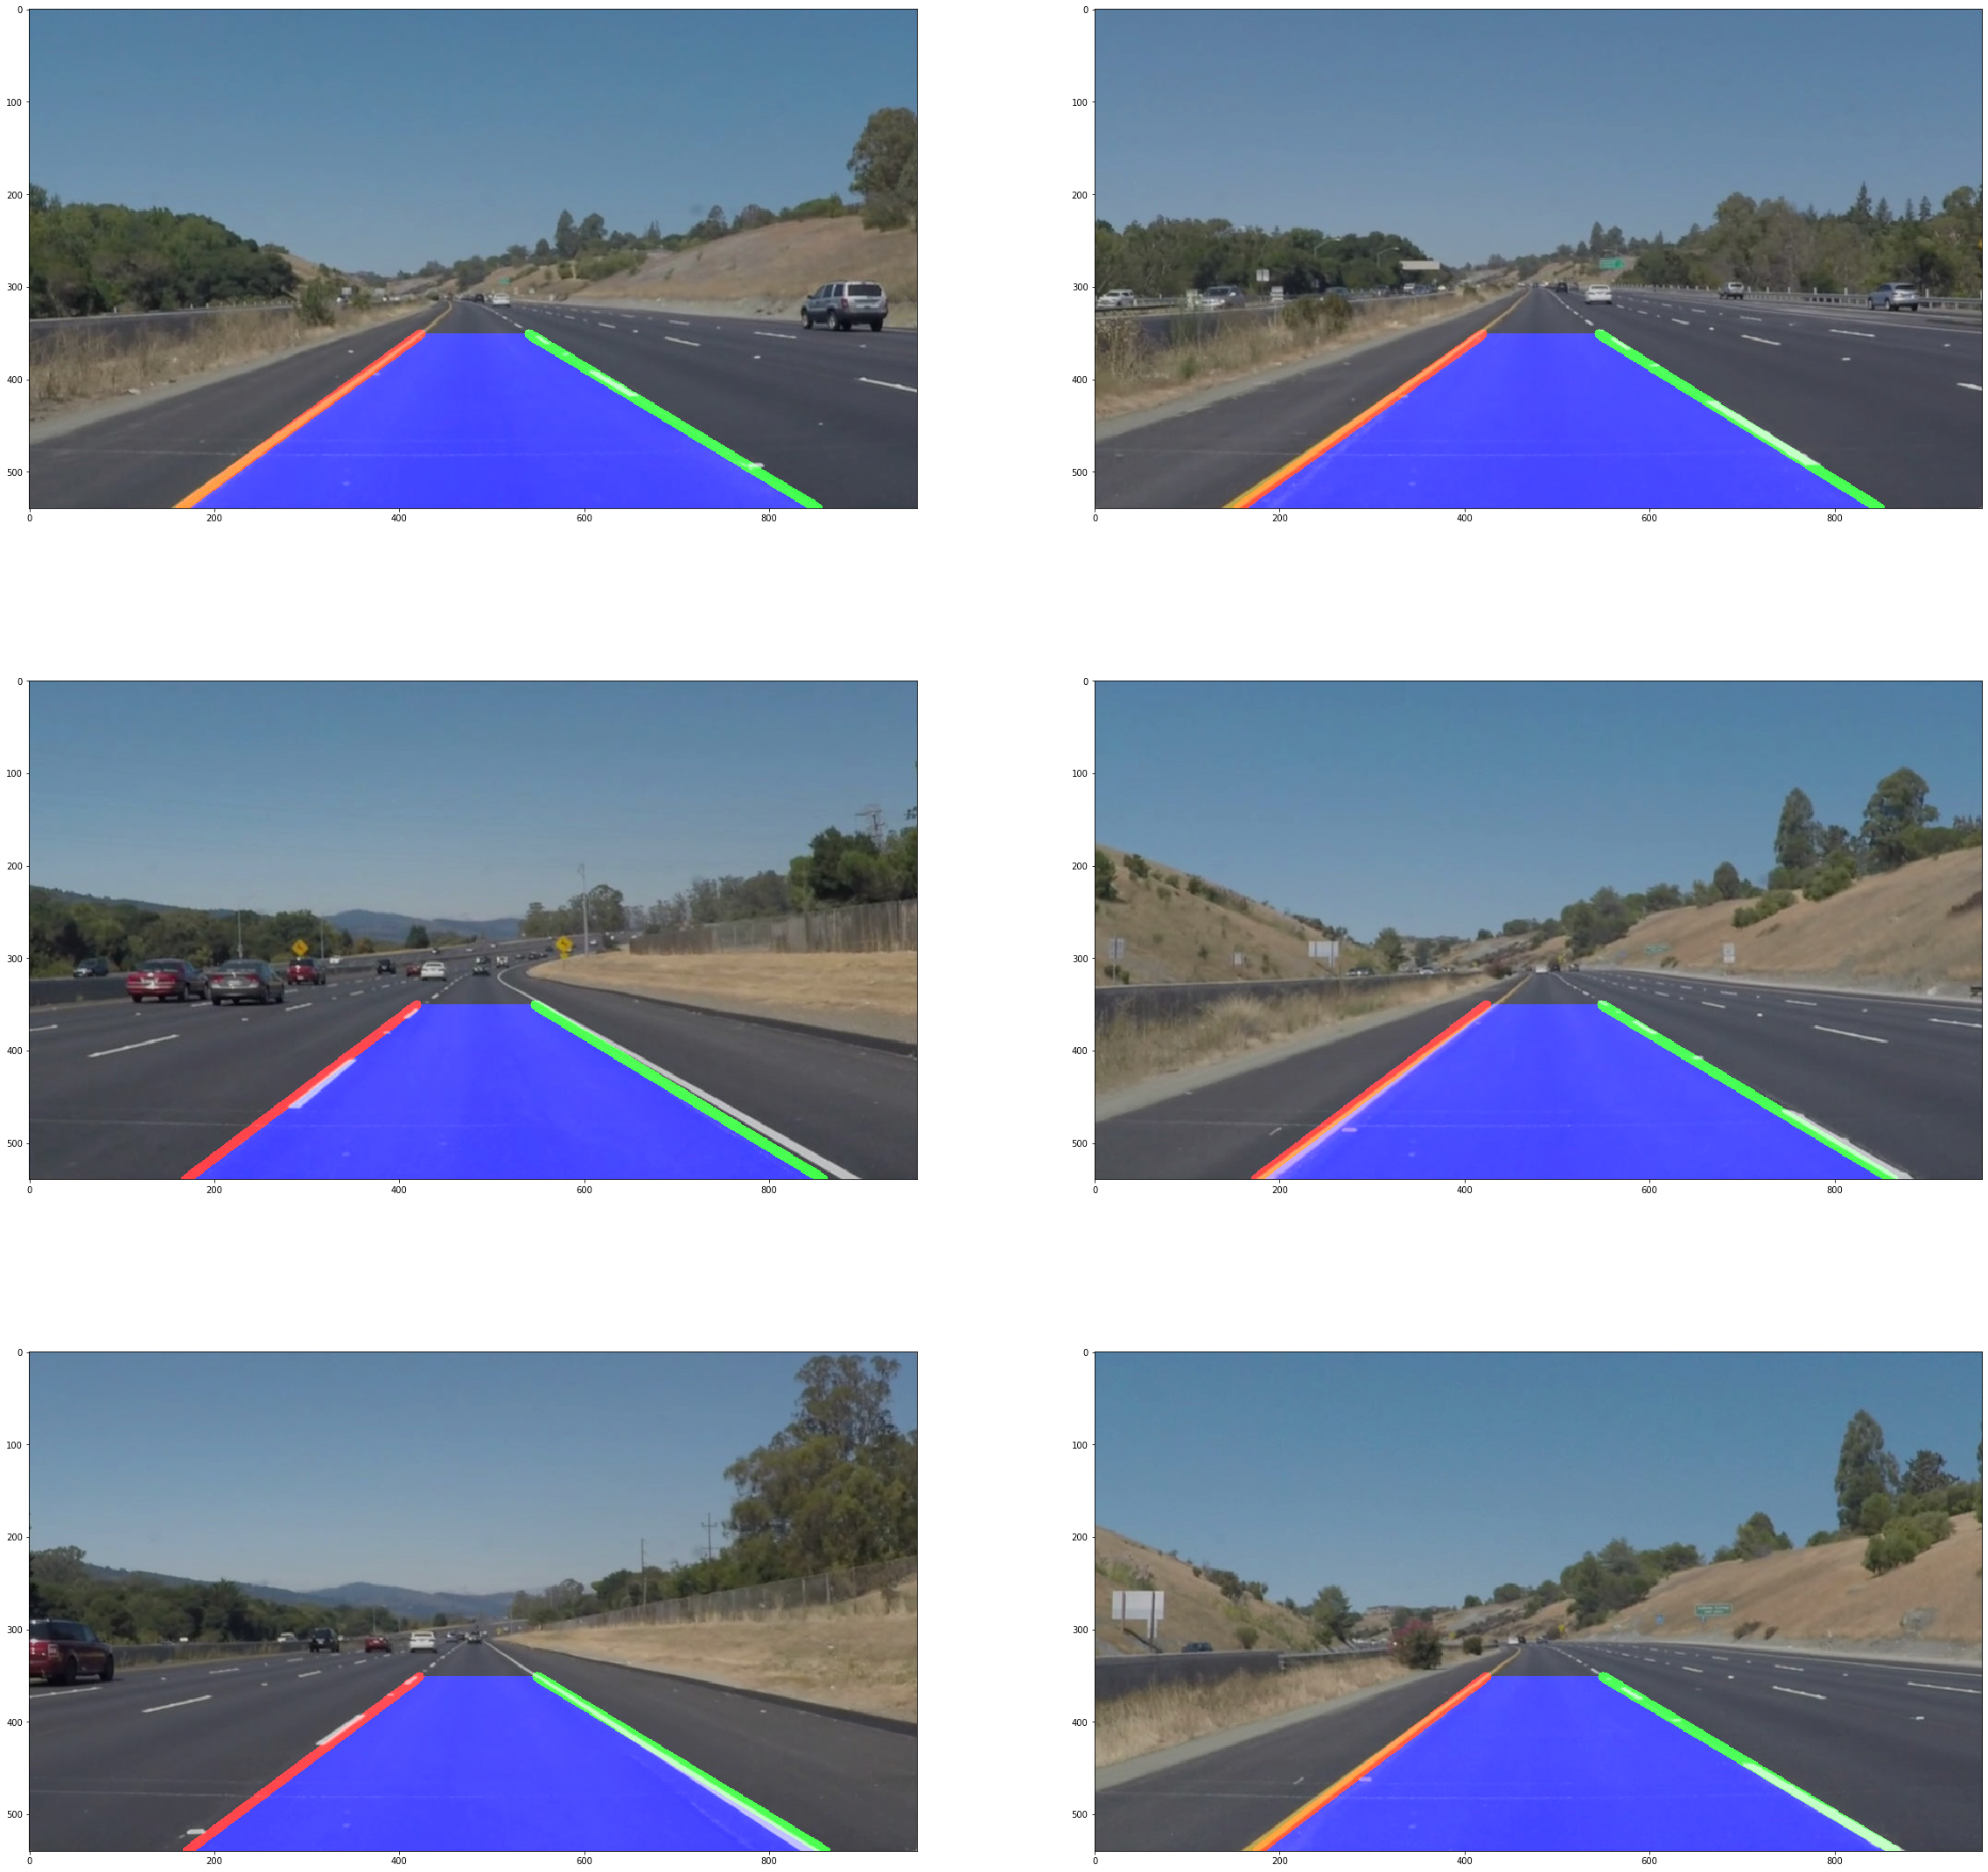

In [9]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def weightSum(input_set):
    img = list(input_set)
    return cv2.addWeighted(img[0], 1, img[1], 0.8, 0)

result_img = list(map(weightSum, zip(hough_img, imageList)))
display_images(result_img)